In [1]:
import gzip
from collections import defaultdict

In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

In [105]:
user_reviews = list(parse('australian_user_reviews.json.gz')) #game reviews

In [5]:
item_descriptions = list(parse('steam_games.json.gz')) #metadata

# Analysis of the data

In [6]:
items = defaultdict(int)
for item in item_descriptions:
    items[item.get('id', '0')] = 0

In [7]:
for user in user_reviews:
    for review in user['reviews']:
        items[review['item_id']] += 1

In [8]:
non_zero = [i for (i, c) in items.items() if c > 0]

In [9]:
# Total number of reviews
sum(items.values())

59305

In [10]:
# Number of games that have reviews
len(non_zero)

3682

In [11]:
list(user_reviews[0].keys())

['user_id', 'user_url', 'reviews']

In [12]:
list(user_reviews[0]['reviews'][0].keys())

['funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review']

In [83]:
user_reviews[0]['reviews'][0]

{'funny': '',
 'posted': 'Posted November 5, 2011.',
 'last_edited': '',
 'item_id': '1250',
 'helpful': 'No ratings yet',
 'recommend': True,
 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}

In [121]:
funnycount = 0
helpfulcount = 0

for l in user_reviews:
    try:
        funny = l['reviews'][0].get('funny').split(' ', 1)[0]
        if not funny in ('', 'No'):
            funnycount += 1 #int(funny.replace(',',''))
        helpful = l['reviews'][0].get('helpful').split(' ', 1)[0]
        if not helpful in ('', 'No'):
            helpfulcount += 1 #int(helpful.replace(',',''))
    except IndexError:
        pass

In [102]:
str = ''
str.split(' ', 1)[0]

''

In [108]:
int('1,130')

ValueError: invalid literal for int() with base 10: '1,130'

In [122]:
helpfulcount

15768

In [123]:
funnycount

4204

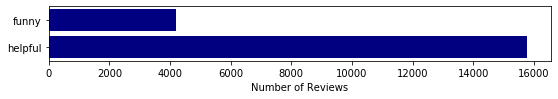

In [127]:
names = ['helpful', 'funny']
values = [helpfulcount, funnycount]

plt.figure(figsize=(9, 1))
plt.barh(names, values, color='navy')
plt.xlabel('Number of Reviews')
plt.show()

In [13]:
list(item_descriptions[0].keys())

['publisher',
 'genres',
 'app_name',
 'title',
 'url',
 'release_date',
 'tags',
 'discount_price',
 'reviews_url',
 'specs',
 'price',
 'early_access',
 'id',
 'developer']

# Data processing

In [14]:
# Map item ids to the corresponding entries
items = { i.get('id', '0'): i for i in item_descriptions }

In [15]:
no_record = 0
no_attr = 0
no_price = 0

def format_review(review):
    item = items.get(review['item_id'], None)
    
    if not item:
        # Non-existent item
        global no_record
        no_record += 1
        return None
    
    if 'genres' not in item.keys() or 'price' not in item.keys() or 'release_date' not in item.keys():
        # Missing attribute
        global no_attr
        no_attr += 1
        return None
    
    date_posted = review['posted'][7:-1]
    
    month_posted = date_posted.split(' ')[0]
    year_posted = int(date_posted.split(' ')[-1])
    
    # Remove old/incorrectly dated reviews
    if year_posted < 2010:
        return None
    
    # if price is not a float, ignore it
    if type(item['price']) == str:
        global no_price
        no_price += 1
        return None
    
    return {
        'text': review['review'],
        'genres': item['genres'],
        'price': item['price'],
        'release_date': item['release_date'],
         # Remove <Posted > part
        'date_posted': review['posted'][7:-1],
        'tags': item['tags']
    }
    

In [16]:
# Create the data list
data = []
for user in user_reviews:
    for review in user['reviews']:
        data.append(format_review(review))
        
data = [d for d in data if d is not None]

In [17]:
len(data)

30179

In [18]:
data[0]

{'text': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.',
 'genres': ['Action'],
 'price': 19.99,
 'release_date': '2009-05-14',
 'date_posted': 'November 5, 2011',
 'tags': ['FPS',
  'Zombies',
  'Co-op',
  'Survival',
  'Action',
  'Multiplayer',
  'Horror',
  'Online Co-Op',
  'Shooter',
  'Gore',
  'Team-Based',
  'First-Person',
  'Moddable',
  'Survival Horror',
  'Great Soundtrack',
  'Singleplayer',
  'Class-Based',
  'Difficult',
  'Comedy',
  'Adventure']}

In [19]:
f'Missing game info: {no_record}; Missing attribute: {no_attr}; Missing price: {no_price}'

'Missing game info: 5317; Missing attribute: 4290; Missing price: 10876'

# Train/Valid data split

In [20]:
# Sort data by the release date
sorted_data = sorted(data, key = lambda x: x['release_date'])

#randomly shuffle the data
import random
random.shuffle(data)

In [21]:
print(data[0])

{'text': 'Not worth the 23 Euros I spent. Fun game, but it gets really boring really fast. Buy it on a sale if anything. Recommended if you want to be a neo-nazistic dictator.', 'genres': ['Indie', 'Simulation', 'Strategy'], 'price': 24.99, 'release_date': '2013-10-14', 'date_posted': 'February 3, 2014', 'tags': ['Simulation', 'Politics', 'Strategy', 'Indie', 'Turn-Based', 'Singleplayer', 'Political', 'Economy', 'Sandbox', 'Management', 'Moddable', 'Difficult', '2D', 'Casual', 'Turn-Based Strategy', 'Education', 'Funny']}


In [189]:
data_train = data[:27000]
data_valid = data[27000:]

In [190]:
Y_train = [d['price'] for d in data_train]
Y_valid = [d['price'] for d in data_valid]

# Review text cleanup

In [30]:
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def clean(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    import string
    table = str.maketrans('', '', punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    
    words = [w for w in words if not w in stop_words]
    stemmed = [porter.stem(word) for word in words]
    
    return ' '.join(stemmed)

In [33]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
    
for d in data:
    d['text'] = clean(d['text'])
    
import string
from nltk.stem.porter import *

wordCount = defaultdict(int) #for bigrams
for d in data:
    words = d['text'].split() # tokenizes
    for w in words:
        wordCount[w] += 1
        
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

counts[:30]

[nltk_data] Downloading package punkt to /Users/nayoung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nayoung/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[(35512, 'game'),
 (9364, 'play'),
 (6160, 'get'),
 (5854, 'like'),
 (5402, 'good'),
 (5366, 'nt'),
 (5345, 'fun'),
 (4973, 'great'),
 (4300, 'one'),
 (3620, 'realli'),
 (3582, 'would'),
 (3371, 'time'),
 (3254, 'make'),
 (3186, 'best'),
 (2715, 'buy'),
 (2549, 'love'),
 (2394, 'much'),
 (2387, 'go'),
 (2312, 'stori'),
 (2297, 'even'),
 (2291, 'amaz'),
 (2079, 'ever'),
 (2063, 'recommend'),
 (2057, 'want'),
 (2025, 'still'),
 (1972, 'thing'),
 (1962, 'awesom'),
 (1961, 'well'),
 (1937, 'peopl'),
 (1866, 'hour')]

In [60]:
import numpy as np
import matplotlib.pyplot as plt

plotwords = counts[:25]
plotwords.sort()
freq = [x[0] for x in plotwords]
word = [x[1] for x in plotwords]

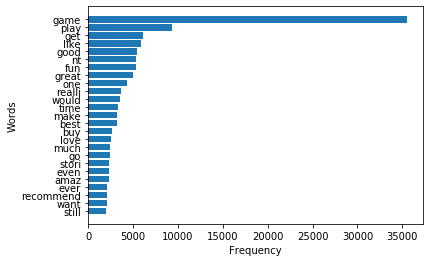

In [61]:
plt.barh(word, width=freq, align='center')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

In [192]:
for d in data_train:
    d['text'] = clean(d['text'])

In [193]:
for d in data_valid:
    d['text'] = clean(d['text'])

In [64]:
wps = defaultdict(float)
wcs = defaultdict(int)
for d in data:
    ws = set(d['tags'])
    for w in ws:
        wps[w] += d['price']
        wcs[w] += 1

wavgp = defaultdict(float)
for w in wps:
    wavgp[w] = wps[w] / wcs[w]
w_avg_prices = [(w, p) for (w, p) in wavgp.items()]
w_avg_prices.sort(key=lambda x: x[1], reverse=True)
w_avg_prices[:50]

[('Web Publishing', 67.93117647058823),
 ('Game Development', 55.799523809523805),
 ('Basketball', 50.49),
 ('Dragons', 47.512435897435715),
 ('Design & Illustration', 47.24),
 ('Audio Production', 46.656666666666666),
 ('Free to Play', 46.1873632812503),
 ('Rome', 45.79303448275849),
 ('MOBA', 41.09052631578948),
 ('America', 37.841351351351165),
 ('Turn-Based Tactics', 35.769354838709575),
 ('Utilities', 35.230000000000004),
 ('Education', 35.185123216602314),
 ('Space Sim', 34.38344262295068),
 ('Hacking', 33.90945833333317),
 ('Real Time Tactics', 33.663068592057634),
 ('Illuminati', 32.89432098765415),
 ('Grand Strategy', 32.31157961783484),
 ('Diplomacy', 31.689779249447938),
 ('TrackIR', 31.67900804289527),
 ('Software Training', 31.35363636363637),
 ('Base Building', 30.832093023256235),
 ('MMORPG', 30.21367537313414),
 ('Futuristic', 29.80746031746026),
 ('4X', 29.722727272727084),
 ('Hex Grid', 29.445242966751746),
 ('Software', 29.127931034482764),
 ('Dinosaurs', 28.60894273

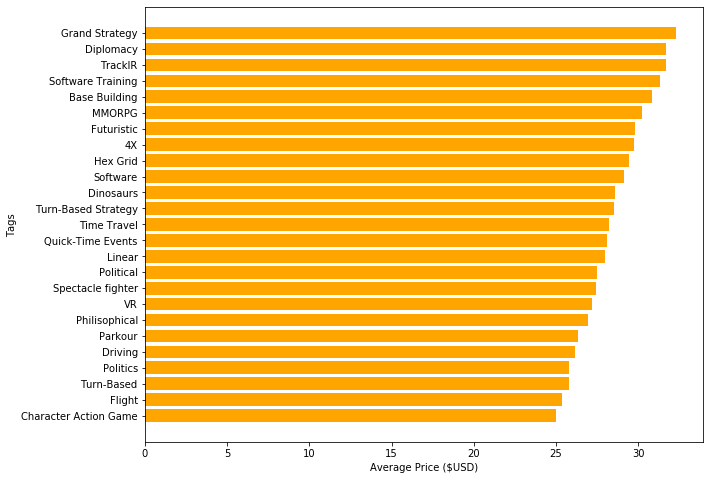

In [97]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plottags = w_avg_prices[17:42]
plottags.sort(key=lambda x: x[1])
price = [x[1] for x in plottags]
tag = [x[0] for x in plottags]

plt.barh(tag, width=price, align='center', color='orange')
plt.xlabel('Average Price ($USD)')
plt.ylabel('Tags')
plt.show()

In [ ]:
price = [x[0] for x in plottags]
tag = [x[1] for x in plottags]

plt.barh(tag, width=price, align='center')
plt.xlabel('Average Price')
plt.ylabel('Tags')
plt.show()

# Feature extraction

In [499]:
months = {
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
}

year = [0] * 6

In [500]:
# one hot encoding for 85 most popular tags
tag_counts = defaultdict(int)

for e in data_train + data_valid:
    for tag in e['tags']:
        tag_counts[tag] += 1

In [501]:
tag_list = [(tag, c) for (tag, c) in tag_counts.items()]

In [502]:
tag_list.sort(key=lambda x: x[1], reverse=True)

In [503]:
tag_choices = [t for (t, c) in tag_list[:100]]

In [504]:
tags = { t: i for (t, i) in zip(tag_choices, range(len(tag_choices))) }

In [508]:
def baseline_feature(entry):
    # no offset term
    feat = []
    
    # one-hot encode tags
    tag_feat = [0] * len(tags.keys())
    for tag in entry['tags']:
        if tag in tags:
            tag_feat[tags[tag]] = 1
        
    # one-hot encode date
    date_feat = [0] * 6 + [0] * 12
    date_posted = entry['date_posted']
    
    month_posted = months[date_posted.split(' ')[0]]
    year_posted = int(date_posted.split(' ')[-1])
    
    date_feat[year_posted - 2010] = 1
    date_feat[4 + month_posted] = 1
    
    feat.extend(date_feat)
    feat.extend(tag_feat)
    
    return feat

# Baseline Model

In [509]:
X_train = [baseline_feature(d) for d in data_train]

In [510]:
len(X_train[0])

118

In [512]:
# 19 labels marked on average
sum([sum(x) for x in X_train]) / len(X_train)

18.910444444444444

In [513]:
X_valid = [baseline_feature(d) for d in data_valid]

In [514]:
len(X_train) == len(Y_train)

True

In [515]:
# sklearn attempt
from sklearn.linear_model import LinearRegression

sk_X = np.array(X_train)
sk_Y = np.array(Y_train)

reg = LinearRegression(normalize=True).fit(sk_X, sk_Y)

reg.score(sk_X, sk_Y)

0.37232878553368487

In [516]:
def predict(theta, X_valid):
    predictions = []
    for e in X_valid:
        predictions.append(sum([a*b for (a, b) in zip(theta, e)]))
    return predictions

In [517]:
predictions = reg.predict(X_valid)

In [518]:
sum([sum(x) for x in X_valid]) / len(X_valid)

18.855300408933626

In [519]:
from sklearn import metrics

In [520]:
metrics.mean_squared_error(Y_valid, predictions)

63.445521437631236

In [521]:
metrics.r2_score(Y_valid, predictions)

0.5527165942288355

# TF-IDF Analysis

In [422]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

In [423]:
vectorizer = tfidf(max_features=7000)

In [424]:
corpus = [d['text'] for d in data_train]
tfidf_result = vectorizer.fit_transform(corpus)

In [425]:
tfidf_result.shape

(27000, 7000)

In [388]:
from sklearn.decomposition import PCA

In [460]:
# reduce dimensionality
pca = PCA(n_components=100)

tfidf_feat = pca.fit_transform(tfidf_result.toarray())

In [461]:
tfidf_feat.shape

(27000, 100)

In [28]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()

wordCount = defaultdict(int) #for bigrams
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    words = r.strip().split() # tokenizes
    for w in words:
        w = stemmer.stem(w)
        wordCount[w] += 1
        
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

counts[:30]

[(47273, 'the'),
 (35068, 'game'),
 (31918, 'and'),
 (31082, 'a'),
 (27183, 'it'),
 (27027, 'to'),
 (22331, 'is'),
 (21564, 'of'),
 (21236, 'i'),
 (20143, 'you'),
 (19333, 'thi'),
 (11947, 'in'),
 (10624, 'that'),
 (10352, 'for'),
 (9593, 'with'),
 (9295, 'play'),
 (8853, 'but'),
 (7611, 'have'),
 (6883, 'on'),
 (6449, 'be'),
 (6422, 'are'),
 (6332, 'as'),
 (6124, 'get'),
 (6013, 'your'),
 (5825, 'like'),
 (5711, 'if'),
 (5344, 'can'),
 (5324, 'good'),
 (5272, 'fun'),
 (5255, 'not')]

In [26]:
counts[:30]

[(10739, 'this game'),
 (5468, 'the game'),
 (4875, 'of the'),
 (4478, 'game is'),
 (3315, 'if you'),
 (3245, 'is a'),
 (2695, '3 3'),
 (2652, 'in the'),
 (2637, 'it is'),
 (2492, 'this is'),
 (2258, 'you can'),
 (1980, 'i have'),
 (1962, 'one of'),
 (1935, 'the best'),
 (1917, 'to the'),
 (1912, 'to play'),
 (1871, 'and the'),
 (1760, 'great game'),
 (1600, 'nyan nyan'),
 (1466, 'to be'),
 (1423, 'and i'),
 (1398, 'is the'),
 (1381, 'game i'),
 (1359, 'a great'),
 (1295, 'with a'),
 (1295, 'game and'),
 (1283, 'on the'),
 (1277, 'for the'),
 (1244, 'a game'),
 (1212, 'good game')]

# With TF-IDF

## Use more tags and review data

In [551]:
tag_choices = [t for (t, c) in tag_list[:150]]
tags = { t: i for (t, i) in zip(tag_choices, range(len(tag_choices))) }

In [552]:
def feature(i, entry):
    feat = []
    
    # get the review tfidf data
    tfidf = tfidf_feat[i]
    
    # one-hot encode tags
    tag_feat = [0] * len(tags.keys())
    for tag in entry['tags']:
        if tag in tags:
            tag_feat[tags[tag]] = 1
    
    # one-hot encode date
    date_feat = [0] * 6 + [0] * 12
    date_posted = entry['date_posted']
    
    month_posted = months[date_posted.split(' ')[0]]
    year_posted = int(date_posted.split(' ')[-1])
    
    date_feat[year_posted - 2010] = 1
    date_feat[4 + month_posted] = 1
    
    feat.extend(date_feat)
    feat.extend(tag_feat)
    feat.extend(tfidf)
    
    return feat

In [553]:
X_train = [feature(i, x) for (i, x) in enumerate(data_train)]

In [554]:
len(X_train) == len(Y_train)

True

In [555]:
len(X_train[0])

268

In [556]:
sk_X = np.array(X_train)
sk_Y = np.array(Y_train)

reg = LinearRegression(normalize=True).fit(sk_X, sk_Y)

reg.score(sk_X, sk_Y)

0.4740225813128263

In [557]:
X_valid = [feature(i, x) for (i, x) in enumerate(data_valid)]

In [558]:
predictions = reg.predict(X_valid)

In [559]:
metrics.mean_squared_error(Y_valid, predictions)

55.70752761725031

In [560]:
metrics.r2_score(Y_valid, predictions)

0.6072685334578091

Best results so far:

tfidf components: 150

tags: 150

r2 = 0.607

m2e = 56.12

# Coefficient analysis:

In [570]:
coefs = reg.coef_
len(coefs)

268

In [571]:
year_coef = coefs[:6]
month_coef = coefs[6:18]
tags_coef = coefs[19:169]
words_coef = coefs[169:]

In [563]:
year_coef

array([-3.26866016, -2.78570152, -2.72560426, -1.05060549, -0.61275363,
        0.58883588])

In [566]:
list(zip(months.keys(), month_coef))

[('January', 0.14334168104279602),
 ('February', 1.0174508761290748),
 ('March', 0.6645028017194995),
 ('April', 0.36814513835958634),
 ('May', 1.1448400148407307),
 ('June', 1.0665462614337027),
 ('July', 0.8124163791751041),
 ('August', 0.7660104907181801),
 ('September', 1.3436723749471253),
 ('October', 0.8883441764267666),
 ('November', -111636763520304.38),
 ('December', -169682808256498.97)]

In [573]:
tag_weights = list(zip(tag_choices, tags_coef))

In [575]:
tag_weights.sort(reverse=True, key=lambda x: x[1])

In [576]:
tag_weights[:5]

[('Episodic', 33.623113175726445),
 ('Violent', 18.464525365245247),
 ('Memes', 9.099876144651885),
 ('Top-Down', 9.06766929456968),
 ('Perma Death', 8.446572632562361)]

In [585]:
r = [(t, c*tag_counts[t]) for (t, c) in tag_weights]
r.sort(reverse=True, key=lambda x: x[1])

In [586]:
r[:5]

[('Online Co-Op', 48157.02423792303),
 ('Moddable', 42320.20943002208),
 ('Adventure', 39078.63796411132),
 ('Third Person', 34113.19623629146),
 ('Tactical', 32968.240913991474)]

In [572]:
sum(words_coef)/len(words_coef)

-0.18081967139927604